### Tarea 2 - Aprendizaje automático

En este cuaderno se desarrollarán los siguientes puntos:

- Construya la arquitectura de una red neuronal Autoencoder en PyTorch
- Escriba el training loop teniendo en cuenta la técnica de Gradient Accumulation. 
- Adapte esos puntos para funcionar con imágenes. Para esto debe investigar Vision Transformers, y explicar la diferencia con redes convolucionales e implementar (pueden usar las capas pre-existentes de PyTorch).
- Escoja un dataset tabular, y usar las técnicas aprendidas de clustering (k-means y DB-Scan), investigar y hacer una implementación desde cero de BFR, y comparar el resultado de los tres.

In [1]:
# Importe de libreras necesarias

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


C:\Users\jmuri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Se realizara la arquitectura del autoencoder lineal y convolucional, pero solo se utilizará  el modelo convolucional para efectos de comparación con Vision Transformers (ViT).

In [ ]:
# Arquitectura del Autoencoder Lineal 

class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super(Autoencoder_Linear, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # Output entre 0 y 1 si los datos están normalizados
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### Creación y entrenamiento del modelo convolucional

In [2]:
#Arquitectura del Autoencoder Convolucional

class Autoencoder_Convolutional(nn.Module):
    def __init__(self):
        super().__init__()   

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) 
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  
            nn.Sigmoid() # Output entre 0 y 1 si los datos están normalizados
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
# Función para graficar las reconstrucciones

def plot_reconstructions(inputs, outputs, epoch, N=8):
    inputs = inputs[:N]
    outputs = outputs[:N].view(-1, 1, 28, 28)

    fig, axes = plt.subplots(2, N, figsize=(N * 0.8, 1.5))
    fig.suptitle(f"Reconstrucciones en época {epoch}", fontsize=14)
    
    for i in range(N):
        axes[0, i].imshow(inputs[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].detach().squeeze(), cmap='gray')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
# Preprocesamiento y datos

# Transformaciones 
transform = transforms.ToTensor()

# Cargar el dataset MNIST
full_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # 60,000 imágenes
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Dividir el dataset en entrenamiento y validación
# Definir tamaños de entrenamiento y validación
train_size = int(0.8 * len(full_train_dataset))   # 80% para entrenamiento (48,000)
val_size = len(full_train_dataset) - train_size   # 20% para validación (12,000)

# Dividir el dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch [1/10], Train Loss: 0.0841, Val Loss: 0.0504
Epoch [2/10], Train Loss: 0.0295, Val Loss: 0.0182


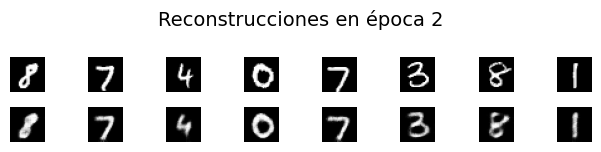

Epoch [3/10], Train Loss: 0.0145, Val Loss: 0.0119
Epoch [4/10], Train Loss: 0.0104, Val Loss: 0.0093


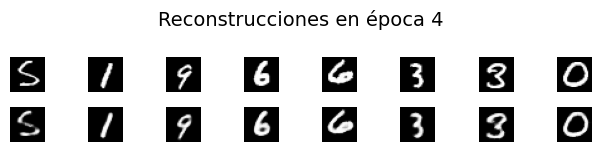

Epoch [5/10], Train Loss: 0.0085, Val Loss: 0.0078
Epoch [6/10], Train Loss: 0.0073, Val Loss: 0.0069


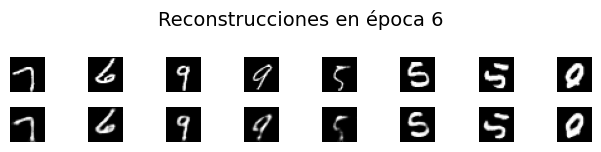

Epoch [7/10], Train Loss: 0.0065, Val Loss: 0.0063
Epoch [8/10], Train Loss: 0.0059, Val Loss: 0.0057


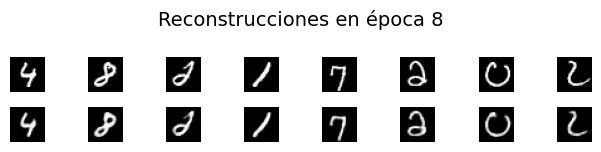

Epoch [9/10], Train Loss: 0.0054, Val Loss: 0.0053
Epoch [10/10], Train Loss: 0.0050, Val Loss: 0.0048


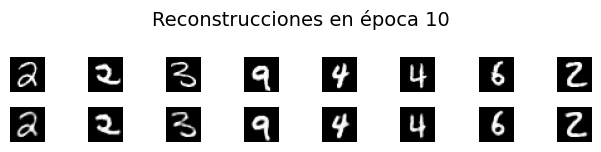

In [5]:
# Modelo, optimizador y función de pérdida

model_c = Autoencoder_Convolutional()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_c.parameters(), lr=1e-3, weight_decay=1e-5)

# Hiperparámetros de Graddient Accumulation

accumulation_steps = 4  
num_epochs = 10


# Training loop

model_c.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (inputs, _) in enumerate(train_loader):
        outputs = model_c(inputs)
        loss = criterion(outputs, inputs)
        loss = loss / accumulation_steps  
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps  # Deshacer la división

    avg_train_loss = running_loss / len(train_loader)

    # Validación

    model_c.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, _ in val_loader:
            val_outputs = model_c(val_inputs)
            loss = criterion(val_outputs, val_inputs)
            val_loss += loss.item() * val_inputs.size(0)
            
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Graficar cada 2 épocas

    if (epoch + 1) % 2 == 0:
        with torch.no_grad():
            sample, _ = next(iter(train_loader))
            reconstructed = model_c(sample)
            plot_reconstructions(sample, reconstructed, epoch+1)
            
    model_c.train()


In [6]:
# Guardar el modelo entrenado

torch.save(model_c.state_dict(), "autoencoder_convolucional.pth")

### Evaluación en test

Pérdida promedio en TEST: 0.0046


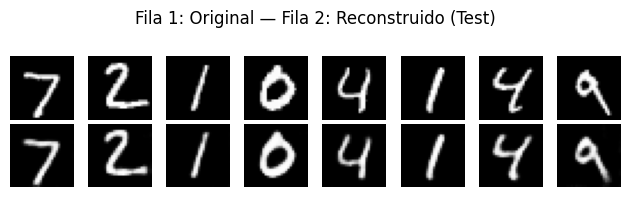

In [7]:
# Cargar el modelo entrenado
model_c = Autoencoder_Convolutional()                
model_c.load_state_dict(torch.load("autoencoder_convolucional.pth"))           
model_c.eval()                                        

# Evaluación cuantitativa en el set de test
test_loss = 0.0
with torch.no_grad():
    for imgs, _ in test_loader:                        
        outputs = model_c(imgs)
        loss = criterion(outputs, imgs)
        test_loss += loss.item() * imgs.size(0)

avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Pérdida promedio en TEST: {avg_test_loss:.4f}")

# Visualización cualitativa 
N = 8
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))           # lote de prueba
    recons = model_c(sample_imgs)[:N]

# Mostrar reconstrucciones
fig, axes = plt.subplots(2, N, figsize=(N*0.8, 2.0))
fig.suptitle("Fila 1: Original — Fila 2: Reconstruido (Test)", fontsize=12)

for i in range(N):
    axes[0, i].imshow(sample_imgs[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recons[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


Tras completar el entrenamiento del autoencoder convolucional y realizar la evaluación sobre el conjunto de prueba (test set), se observa que el modelo logró una excelente capacidad de generalización. La pérdida promedio en el test fue del 0.0046, es decir, fue muy baja, lo que indica que el modelo es capaz de reconstruir imágenes nunca vistas durante el entrenamiento con alta fidelidad.

Además, la inspección visual de los resultados mostró que las reconstrucciones conservan de manera clara la forma, trazo y estructura de los dígitos originales, incluso en ejemplos difíciles. Esto sugiere que el modelo ha aprendido representaciones latentes significativas y robustas, capturando los patrones del conjunto MNIST.

En conjunto, tanto las métricas cuantitativas como la evaluación cualitativa respaldan que el modelo tuvo un desempeño sobresaliente.

## Vision Transformers (ViT): 
Implementación y comparación con redes convolucionales.

### ¿En que consiste ViT?
Vision Transformer (ViT) es una arquitectura basada en transformadores adaptada específicamente para tareas de visión por computador. A diferencia de las redes convolucionales tradicionales, ViT procesa las imágenes dividiéndolas en pequeños parches de tamaño fijo, los cuales se aplanan y se tratan como una secuencia de tokens, de forma análoga a las palabras en tareas de procesamiento de lenguaje natural (NLP).

Cada parche es proyectado a un espacio de mayor dimensión mediante una capa lineal, y se le suma una codificación posicional para conservar la información espacial. Estos tokens enriquecidos se ingresan a una pila de bloques de atención (transformer encoder), donde el modelo aprende relaciones globales entre parches.

### Comparación entre redes convolucionales y Vision transformers

A continuación se presenta una tabla que contrasta las características principales de las redes convolucionales (CNN) y los Vision Transformers (ViT). La comparación abarca aspectos técnicos relevantes como la forma en que procesan las imágenes, su capacidad para capturar contexto espacial, la eficiencia computacional y su adaptabilidad a distintas tareas de visión artificial. Esta síntesis facilita una visión clara de las diferencias clave entre ambos enfoques.



| Dimensión                            | CNN                                                                        | Vision Transformer                                                                              |
| ------------------------------------ | -------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------- |
| **Bloque básico**                    | Convolución: kernels locales que barren la imagen.                         | *Self-attention* global: cada parche “se fija” en todos los demás.                              |
| **Sesgo inductivo**                  | Fuerte: invarianza a traslación, jerarquía espacial implícita.             | Débil: apenas asume estructura; aprende las relaciones desde los datos.                         |
| **Contexto espacial**                | El campo receptivo crece capa a capa; el contexto global se alcanza tarde. | Desde el primer bloque, el modelo accede a la imagen completa.                                  |
| **Codificación posicional**          | Implícita en la operación de convolución.                                  | Requiere codificación posicional explícita en cada token.                                       |
| **Parámetros y coste**               | Menos costosas en FLOPs y memoria; ideales para dispositivos embebidos.    | Atención cuadrática respecto al número de parches; más costoso computacionalmente.              |
| **Necesidad de datos**               | Buen rendimiento con datasets moderados gracias al sesgo inductivo.        | Requieren preentrenamiento en grandes conjuntos de datos para alcanzar buenos resultados.       |
| **Flexibilidad entre tareas**        | Diseños específicos por tarea (U-Net, FPN, etc.).                          | Arquitectura general que se adapta fácilmente a segmentación, captioning y tareas multimodales. |
| **Rendimiento en dispositivos edge** | Más eficientes; comúnmente preferidas para tiempo real.                    | ViTs aún son pesadas; se investiga su aceleración o uso híbrido con CNN.                        |
| **Interpretabilidad**                | Filtros locales permiten usar mapas de activación (CAM/Grad-CAM).          | Mapas de atención ofrecen trazabilidad clara sobre qué partes de la imagen “observa” el modelo. |

Visto esto desarrollemos una implementación basada en Vision transformers para el conjunto de datos previamente tratado en la primera parte de esta tarea.

### Creación y entrenamiento del modelo de ViT 

In [8]:
class ViTAutoencoder(nn.Module):
    def __init__(self, image_size=28, patch_size=7, emb_dim=64, depth=4, n_heads=4):
        super(ViTAutoencoder, self).__init__()

        assert image_size % patch_size == 0, "El tamaño de imagen debe ser divisible por el tamaño del parche"
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = patch_size * patch_size  # solo un canal (grayscale MNIST)

        # Patch embedding (Linear)
        self.patch_embed = nn.Linear(self.patch_dim, emb_dim)

        # Positional embeddings (aprendidos)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, emb_dim))

        # Encoder: TransformerEncoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Decoder: reconstruye cada patch y luego reensambla
        self.decoder = nn.Sequential(
            nn.Linear(emb_dim, self.patch_dim),
            nn.Sigmoid()  # reconstrucción normalizada
        )

    def forward(self, x):
        B, C, H, W = x.shape  # (batch, 1, 28, 28)

        # 1. Dividir en parches
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(B, -1, self.patch_dim)  # (B, N_patches, patch_dim)

        # 2. Embedding + posición
        tokens = self.patch_embed(patches) + self.pos_embed  # (B, N, emb_dim)

        # 3. Transformer encoder
        encoded = self.encoder(tokens)

        # 4. Decoder (reconstrucción de cada patch)
        decoded_patches = self.decoder(encoded)  # (B, N, patch_dim)

        # 5. Reensamblar imagen
        patches_per_row = H // self.patch_size
        recon = decoded_patches.view(B, patches_per_row, patches_per_row, self.patch_size, self.patch_size)
        recon = recon.permute(0, 1, 3, 2, 4).contiguous().view(B, 1, H, W)

        return recon

In [14]:
# Definimos nuevamente ciertos elementos para enfatizar en la implementación de ViT

# Configuración del modelo, criterio y optimizador

model_v = ViTAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_v.parameters(), lr=1e-3, weight_decay=1e-5)

# Hiperparámetros de Graddient Accumulation

accum_steps = 4
num_epochs = 6

Epoch [1/6] - Train Loss: 0.0663 | Val Loss: 0.0187
Epoch [2/6] - Train Loss: 0.0111 | Val Loss: 0.0051


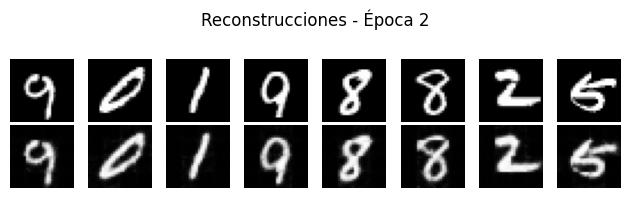

Epoch [3/6] - Train Loss: 0.0045 | Val Loss: 0.0025
Epoch [4/6] - Train Loss: 0.0027 | Val Loss: 0.0017


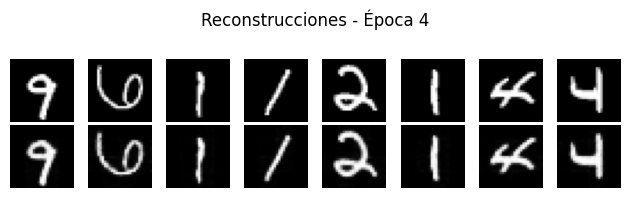

Epoch [5/6] - Train Loss: 0.0020 | Val Loss: 0.0014
Epoch [6/6] - Train Loss: 0.0016 | Val Loss: 0.0012


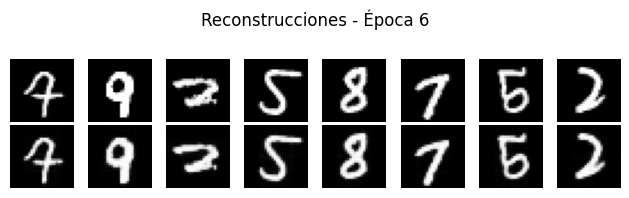

In [15]:
# Entrenamiento

model_v.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (inputs, _) in enumerate(train_loader):
        outputs = model_v(inputs)
        loss = criterion(outputs, inputs) / accum_steps
        loss.backward()

        if (i + 1) % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accum_steps

    avg_train_loss = running_loss / len(train_loader)

    # Validación 

    model_v.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, _ in val_loader:
            val_outputs = model_v(val_inputs)
            loss = criterion(val_outputs, val_inputs)
            val_loss += loss.item() * val_inputs.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Visualización cada 2 épocas 

    if (epoch + 1) % 2 == 0:
        with torch.no_grad():
            sample_imgs, _ = next(iter(train_loader)) 
            recon_imgs = model_v(sample_imgs)

        N = 8
        fig, axes = plt.subplots(2, N, figsize=(N * 0.8, 2.0))
        fig.suptitle(f"Reconstrucciones - Época {epoch+1}", fontsize=12)

        for j in range(N):
            axes[0, j].imshow(sample_imgs[j].squeeze(), cmap='gray')
            axes[0, j].axis('off')
            axes[1, j].imshow(recon_imgs[j].squeeze(), cmap='gray')
            axes[1, j].axis('off')

        plt.tight_layout()
        plt.show()

    model_v.train()



In [ ]:
# Guardar el modelo entrenado

torch.save(model_v.state_dict(), "autoencoder_vit.pth")

### Evaluación en test

Pérdida promedio en TEST: 0.0012


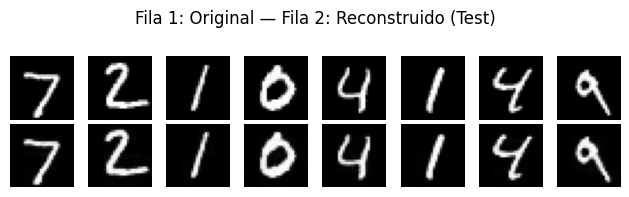

In [18]:
# Cargar el modelo entrenado
model_v = ViTAutoencoder()                
model_v.load_state_dict(torch.load("autoencoder_vit.pth"))           
model_v.eval()                                        

# Evaluación cuantitativa en el set de test

test_loss = 0.0
with torch.no_grad():
    for imgs, _ in test_loader:                        
        outputs = model_v(imgs)
        loss = criterion(outputs, imgs)
        test_loss += loss.item() * imgs.size(0)

avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Pérdida promedio en TEST: {avg_test_loss:.4f}")

# Visualización cualitativa 

N = 8
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))           
    recons = model_v(sample_imgs)[:N]

# Mostrar reconstrucciones

fig, axes = plt.subplots(2, N, figsize=(N*0.8, 2.0))
fig.suptitle("Fila 1: Original — Fila 2: Reconstruido (Test)", fontsize=12)

for i in range(N):
    axes[0, i].imshow(sample_imgs[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recons[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Conclusión comparativa del entrenamiento: CNN vs Vision Transformer

Durante el desarrollo del proyecto se entrenaron dos modelos autoencoder sobre el conjunto de datos MNIST: uno basado en una arquitectura convolucional tradicional y otro en una arquitectura Vision Transformer (ViT). Los resultados obtenidos muestran una ventaja clara del modelo ViT tanto en términos de pérdida como en eficiencia de aprendizaje (necesidad de menor número de épocas).

Aunque el modelo convolucional fue entrenado durante 10 épocas, el modelo ViT logró una convergencia más rápida y efectiva en solo 6 épocas, reduciendo el tiempo total de entrenamiento sin sacrificar calidad. Esto se evidenció en las pérdidas promedio obtenidas en entrenamiento, validación y prueba, como se resume a continuación:

| Métrica                                 | Autoencoder Convolucional | Vision Transformer (ViT) |
| --------------------------------------- | ------------------------- | ------------------------ |
| Épocas de entrenamiento                 | 10                        | 6                        |
| Pérdida en entrenamiento (última época) | 0.0050                    | 0.0016                   |
| Pérdida en validación (última época)    | 0.0048                    | 0.0012                   |
| Pérdida promedio en test                | 0.0046                    | 0.0012                   |
| Tiempo de ejecución por época           | Bajo                      | Alto                     |


El modelo ViT no solo alcanzó un mejor rendimiento con menos épocas, sino que también obtuvo una pérdida en el conjunto de prueba significativamente menor (0.0012 vs 0.0046), lo cual indica una capacidad superior para generalizar a datos no vistos.

#### Análisis de rendimiento:
Este mejor desempeño se debe, en gran parte, a las propiedades estructurales del Vision Transformer:

- Su mecanismo de self-attention permite capturar relaciones globales entre los parches de la imagen desde las primeras capas, lo que facilita una reconstrucción más coherente de la forma completa de los dígitos.

- Su arquitectura, menos condicionada por sesgos espaciales rígidos como en las CNN, ofrece una mayor flexibilidad y capacidad expresiva.

Gracias a esto, el ViT fue capaz de reconstruir las imágenes con mayor precisión, incluso en casos donde las redes convolucionales tienden a perder detalles.

**Consideración adicional:** 
El único aspecto menos favorable del modelo ViT es su mayor tiempo de ejecución por época, debido al coste computacional del mecanismo de atención. Sin embargo, dada la reducción en el número total de épocas necesarias y la mejora notable en la calidad de reconstrucción, este trade-off resulta positivo para la tarea evaluada.

En conjunto, los resultados respaldan que el Vision Transformer es una alternativa robusta, precisa y eficaz para tareas de reconstrucción de imágenes, incluso en conjuntos simples como MNIST.